In [2]:
get_ipython().system('pip install matplotlib')
get_ipython().system('pip install utils')
get_ipython().system('pip install imgaug')
get_ipython().system('pip install eventlet')
get_ipython().system('pip install flask')
from utils import *
import pandas as pd
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from PIL import Image


# In[6]:


def getName(filePath):
    return filePath.split('\\')[-1]
    


def importDataInfo(path):
    # require to upload entire dataset folder and create join path but faile to do so
    coloums=['Center','left','Right','Steering','Throttle','Break','Speed']
    data=pd.read_csv(os.path.join(path,'driving_log.csv'),names=coloums)
    data['Center']=data['Center'].apply(getName)
    print('Total Images Imported:',data.shape[0])
    return data


def balanceData(data, display=True):
    nBins = 31
    samplePerBin = 1000
    hist, bins = np.histogram(data['Steering'], nBins)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        print(center)
        plt.bar(center, hist, width=0.06)
        plt.plot(-1, 1), (samplePerBin, samplePerBin)
        plt.show()
    # remove redundant data
    removeIndexList = []
    for j in range(nBins):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplePerBin:]
        removeIndexList.extend(binDataList)
    print("Remove Images:", len(removeIndexList))
    data.drop(data.index[removeIndexList], inplace=True)
    print('Remaining Images:', len(data))

    if display:
        hist, bins = np.histogram(data['Steering'], nBins)
        plt.bar(center, hist, width=0.06)
        plt.plot(-1, 1), (samplePerBin, samplePerBin)
        plt.show()
    return data

def loadData(path,data):
    imagesPath=[]
    steering=[]
    for i in range (len(data)):
        indexedData= data.iloc[i]
        imagesPath.append(os.path.join(path,'IMG',indexedData[0]))
        steering.append(float(indexedData[3]))
    imagesPath=np.asarray(imagesPath)
    steering=np.asarray(steering)
    return imagesPath,steering


def augmentImage(imgPath, steering):
    img = mpimg.imread(imgPath)
    ##PaN
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
        img = pan.augment_image(img)
    ##Zoom
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    ##Brightness
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.4, 1.2))
        img = brightness.augment_image(img)
    ##Flip
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering

    return img, steering
#imgRe, st= augmentImage('test.jpg',0)
#plt.imshow(imgRe)
#plt.show()

#Crop images
def preProcessing(img):
    img=img[60:135,:,:]
    img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    img=cv2.GaussianBlur(img,(3,3),0)
    img=cv2.resize(img,(200,66))
    img=img/255
    return img


def batchGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            img = preProcessing(img)
            imgBatch.append(img)
            steeringBatch.append(steering)

        yield (np.asarray(imgBatch), np.asarray(steeringBatch))



# In[7]:


def createModel():
    model = Sequential()
    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))

    model.add(Flatten())
    model.add(Dense(100, activation="elu"))
    model.add(Dense(50, activation="elu"))
    model.add(Dense(10, activation="elu"))
    model.add(Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=opt)
    #model.compile(Adam(lr=0.0001,loss='mse'))

    return model



  Using cached utils-1.0.1-py2.py3-none-any.whl (21 kB)
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)
  Using cached Shapely-1.8.5.post1-cp39-cp39-win_amd64.whl (1.3 MB)
  Using cached eventlet-0.33.2-py2.py3-none-any.whl (226 kB)
  Using cached dnspython-2.2.1-py3-none-any.whl (269 kB)


Total Images Imported: 5370
Remove Images: 3340
Remaining Images: 2030
Track1\IMG\center_2022_12_04_15_15_14_876.jpg -0.15
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         

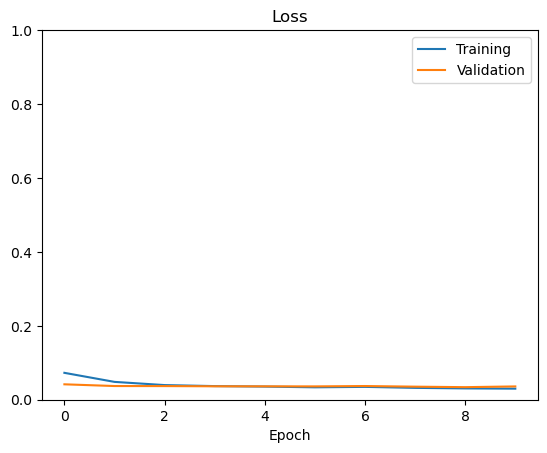

In [5]:
path='Track1'
data= importDataInfo(path)


# In[20]:


data=balanceData(data,display=False)


# In[21]:


imagesPath,steering=loadData(path,data)
print(imagesPath[0], steering[0])


# In[22]:


model= createModel()
model.summary()


# In[23]:


xTrain,xVal,yTrain, yVal = train_test_split(imagesPath, steering, test_size=0.2, random_state=5)
print('Total Training Images:', len(xTrain))
print('Total Validation Images:',len(xVal))


# In[27]:


history=model.fit(batchGen(xTrain,yTrain,100,1),steps_per_epoch=300,epochs=10,
         validation_data=batchGen(xVal,yVal,100,0),validation_steps=200)


# In[26]:


model.save('model.h5')
print("Model Saved")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.ylim([0,1])
plt.title('Loss')
plt.xlabel("Epoch")
plt.show()
